# UCR Dataset: Wafer

**Dataset Homepage:** https://timeseriesclassification.com/description.php?Dataset=Wafer.

### 1. Environment set-up

1. This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. Some hands-on experience using [Amazon SageMaker](https://aws.amazon.com/sagemaker/).
1. To use this algorithm successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to the [Time Series Classification (Inception) Algorithm from AWS Marketplace](https://aws.amazon.com/marketplace/pp/prodview-omz7rumnllmla).

To subscribe to the algorithm:
1. Open the algorithm listing page.
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you agree with EULA, pricing, and support terms. 
1. Once you click on the **Continue to configuration** button and then choose a **region**, you will see a **Product ARN**. This is the algorithm ARN that you need to specify while training a custom ML model. **Copy the ARN corresponding to your region and specify the same in the following cell.**

In [1]:
# SageMaker algorithm ARN from AWS Marketplace
algo_arn = "arn:aws:sagemaker:<...>"

In [2]:
import io
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# SageMaker session
sagemaker_session = sagemaker.Session()

# SageMaker role
role = sagemaker.get_execution_role()

# S3 bucket
bucket = sagemaker_session.default_bucket()

# EC2 instance
instance_type = "ml.m5.2xlarge"

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### 2. Data preparation

#### 2.1 Training dataset

Load the training data.

In [3]:
training_dataset = pd.DataFrame(data=np.genfromtxt("Wafer_TRAIN.txt"))

In [4]:
training_dataset.shape

(1000, 153)

In [5]:
training_dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,143,144,145,146,147,148,149,150,151,152
0,1.0,-1.602294,-1.670823,-1.693666,-1.699377,-1.699377,-1.703660,-1.703660,-1.703660,-1.703660,...,-1.145432,-1.145432,-1.145432,-1.145432,-1.145432,-1.145432,-1.145432,-1.145432,-1.145432,-1.145432
1,1.0,1.084591,1.084591,1.084591,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308,...,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308,1.065308
2,1.0,0.362689,0.362689,0.362689,0.393316,0.362689,0.362689,0.362689,0.362689,0.362689,...,0.393316,0.393316,0.393316,0.362689,0.393316,0.393316,0.393316,0.393316,0.393316,0.393316
3,1.0,-1.094523,-1.094523,-1.094523,-1.096732,-1.094523,-1.096732,-1.094523,-1.094523,-1.094523,...,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732,-1.096732
4,1.0,-1.103761,-1.103761,-1.103761,-1.103761,-1.103761,-1.103761,-1.103761,-1.103761,-1.103761,...,-1.103761,-1.103761,-1.103761,-1.103761,-1.103761,-1.103761,-1.103761,-1.103761,-1.103761,-1.103761


In [6]:
training_dataset.iloc[:, 0].sort_values().unique()

array([-1.,  1.])

In [7]:
training_dataset.iloc[:, 0].rename(None).value_counts().sort_index()

-1.0     97
 1.0    903
Name: count, dtype: int64

Visualize the training data.

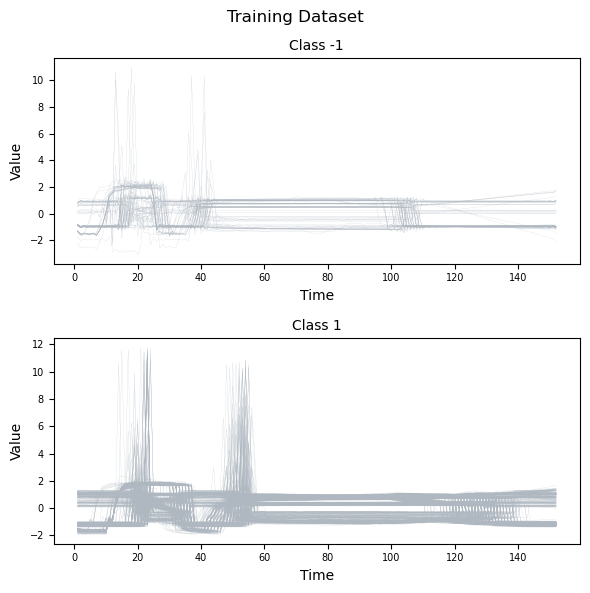

In [8]:
fig, axs = plt.subplots(nrows=training_dataset.iloc[:, 0].nunique(), ncols=1, sharex=True, figsize=(6, 6))
for i, c in enumerate(training_dataset.iloc[:, 0].sort_values().unique()):
    axs[i].plot(training_dataset[training_dataset.iloc[:, 0] == c].iloc[:, 1:].transpose(), color="#AFB8C1", lw=0.1)
    axs[i].set_title(f"Class {int(c)}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.suptitle("Training Dataset")
fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.show()

Upload the training data to S3.

In [9]:
training_data = sagemaker_session.upload_string_as_file_body(
    body=training_dataset.to_csv(index=False, header=False),
    bucket=bucket,
    key="Wafer_train.csv"
)

In [10]:
training_data

's3://sagemaker-eu-west-1-661670223746/Wafer_train.csv'

#### 2.2 Test dataset

Load the test data.

In [11]:
test_dataset = pd.DataFrame(data=np.genfromtxt("Wafer_TEST.txt"))

In [12]:
test_dataset.shape

(6164, 153)

In [13]:
test_dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,143,144,145,146,147,148,149,150,151,152
0,1.0,-1.079707,-1.083256,-1.079707,-1.079707,-1.079707,-1.079707,-1.079707,-1.079707,-1.079707,...,-1.079707,-1.079707,-1.079707,-1.079707,-1.079707,-1.079707,-1.079707,-1.079707,-1.079707,-1.079707
1,1.0,-1.080197,-1.078021,-1.078021,-1.078021,-1.078021,-1.078021,-1.080197,-1.078021,-1.078021,...,-1.110670,-1.112846,-1.115023,-1.117199,-1.119376,-1.121553,-1.123729,-1.125906,-1.128082,-1.130259
2,1.0,-1.154060,-1.154060,-1.154060,-1.154060,-1.154060,-1.154060,-1.154060,-1.154060,-1.154060,...,-1.154060,-1.154060,-1.154060,-1.154060,-1.154060,-1.154060,-1.154060,-1.154060,-1.154060,-1.154060
3,1.0,-1.658965,-1.696605,-1.705291,-1.711082,-1.711082,-1.715425,-1.715425,-1.715425,-1.715425,...,-1.149382,-1.149382,-1.149382,-1.149382,-1.149382,-1.149382,-1.149382,-1.149382,-1.149382,-1.149382
4,1.0,-1.201221,-1.199042,-1.199042,-1.201221,-1.199042,-1.199042,-1.199042,-1.199042,-1.199042,...,-1.185968,-1.183789,-1.181610,-1.179431,-1.177251,-1.175072,-1.172893,-1.170714,-1.168535,-1.166356


In [14]:
test_dataset.iloc[:, 0].sort_values().unique()

array([-1.,  1.])

In [15]:
test_dataset.iloc[:, 0].rename(None).value_counts().sort_index()

-1.0     665
 1.0    5499
Name: count, dtype: int64

Visualize the test data.

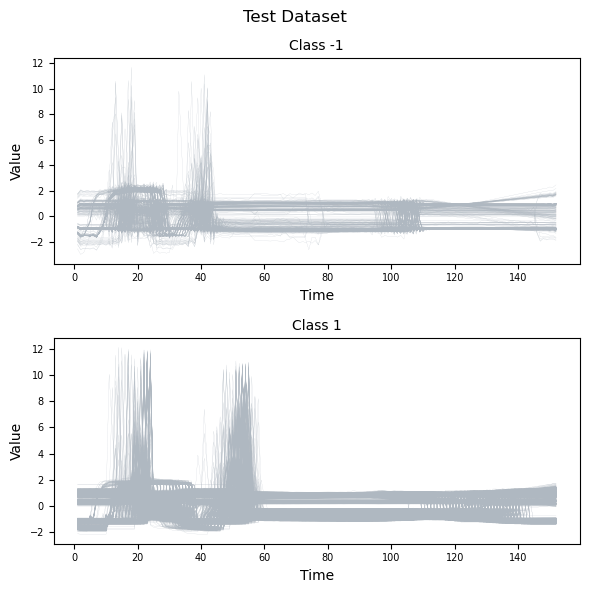

In [16]:
fig, axs = plt.subplots(nrows=test_dataset.iloc[:, 0].nunique(), ncols=1, sharex=True, figsize=(6, 6))
for i, c in enumerate(test_dataset.iloc[:, 0].sort_values().unique()):
    axs[i].plot(test_dataset[test_dataset.iloc[:, 0] == c].iloc[:, 1:].transpose(), color="#AFB8C1", lw=0.1)
    axs[i].set_title(f"Class {int(c)}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.suptitle("Test Dataset")
fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.show()

### 3. Training

Fit the model to the training data.

In [17]:
estimator = sagemaker.algorithm.AlgorithmEstimator(
    algorithm_arn=algo_arn,
    role=role,
    instance_count=1,
    instance_type=instance_type,
    input_mode="File",
    sagemaker_session=sagemaker_session,
    hyperparameters={
        "filters": 32,
        "depth": 6,
        "models": 5,
        "batch-size": 64,
        "lr": 0.0001,
        "lr-decay": 1.0,
        "epochs": 20,
    },
)

estimator.fit({"training": training_data})

INFO:sagemaker:Creating training-job with name: inception-time-v1-7-2023-12-19-15-17-52-996


2023-12-19 15:17:53 Starting - Starting the training job...
2023-12-19 15:18:08 Starting - Preparing the instances for training......
2023-12-19 15:19:06 Downloading - Downloading input data...
2023-12-19 15:19:26 Downloading - Downloading the training image...............
2023-12-19 15:22:07 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-12-19 15:22:28,409 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-12-19 15:22:28,410 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-12-19 15:22:28,411 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-12-19 15:22:28,422 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-12-19 15:22:28,424 sagemaker_pytorch_container.training INFO     Invoking

### 4. Inference

Deploy the model to a real-time endpoint.

In [18]:
serializer = sagemaker.serializers.CSVSerializer(content_type="text/csv")
deserializer = sagemaker.deserializers.CSVDeserializer(accept="text/csv")

In [19]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    serializer=serializer,
    deserializer=deserializer,
)

INFO:sagemaker:Creating model package with name: inception-time-v1-7-2023-12-19-15-33-53-359


.........

INFO:sagemaker:Creating model with name: inception-time-v1-7-2023-12-19-15-33-53-359


INFO:sagemaker:Creating endpoint-config with name inception-time-v1-7-2023-12-19-15-33-53-359
INFO:sagemaker:Creating endpoint with name inception-time-v1-7-2023-12-19-15-33-53-359


--------!

Invoke the endpoint.

In [20]:
batch_size = 100

predictions = pd.DataFrame()

for i in range(0, len(test_dataset), batch_size):

    response = sagemaker_session.sagemaker_runtime_client.invoke_endpoint(
        EndpointName=predictor.endpoint_name,
        ContentType="text/csv",
        Body=serializer.serialize(test_dataset.iloc[i:i + batch_size, 1:].to_csv(index=False, header=False))
    )

    predictions = pd.concat([
        predictions,
        pd.DataFrame(
            data=deserializer.deserialize(response["Body"], content_type="text/csv"),
            dtype=float
        )
    ], axis=0)

In [21]:
predictions.shape

(6164, 1)

In [22]:
predictions.head()

,0
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [23]:
predictions.iloc[:, 0].sort_values().unique()

array([-1.,  1.])

In [24]:
predictions.iloc[:, 0].rename(None).value_counts().sort_index()

-1.0     683
 1.0    5481
Name: count, dtype: int64

Calculate the classification metrics.

In [25]:
metrics = pd.DataFrame(classification_report(y_true=test_dataset.iloc[:, 0], y_pred=predictions.iloc[:, 0], output_dict=True))

In [26]:
metrics

,-1.0,1.0,accuracy,macro avg,weighted avg
precision,0.973646,1.000000,0.99708,0.986823,0.997157
recall,1.000000,0.996727,0.99708,0.998363,0.997080
f1-score,0.986647,0.998361,0.99708,0.992504,0.997097
support,665.000000,5499.000000,0.99708,6164.000000,6164.000000


Delete the model.

In [27]:
predictor.delete_model()

INFO:sagemaker:Deleting model with name: inception-time-v1-7-2023-12-19-15-33-53-359


Delete the endpoint.

In [28]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: inception-time-v1-7-2023-12-19-15-33-53-359
INFO:sagemaker:Deleting endpoint with name: inception-time-v1-7-2023-12-19-15-33-53-359
